In [29]:
import os
import glob
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

from matplotlib import pyplot as plt
%matplotlib inline

from werdich_cfr.tfutils.tfutils import use_gpu_devices
from werdich_cfr.tfutils.TFRprovider import DatasetProvider
from werdich_cfr.tfutils.Modeltrainer import VideoTrainer
from werdich_cfr.utils.visuals import ImageSliceViewer3D

%load_ext autoreload
%autoreload 2

physical_devices, device_list = use_gpu_devices(gpu_device_string='2,3')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
AVAILABLE GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
TRAIN DEVICE LIST:
/GPU:0
/GPU:1


### Recover data from TFRecords: look at the postprocessed images ###

In [30]:
# Directories and files
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
meta_date = '200425'
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date, 'global')
meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)

# TFR file
tfr_file = os.path.join(tfr_dir, 'cfr_global_a4c_train_200425_2.tfrecords')
parquet_file = os.path.join(tfr_dir, 'cfr_global_a4c_train_200425_2.parquet')

# feature_dict
feature_dict_file = os.path.join(tfr_dir, 'global_pet_echo_dataset_200425.pkl')
with open(feature_dict_file, 'rb') as fl:
    feature_dict = pickle.load(fl)

# Load df 
df = pd.read_parquet(parquet_file)
df.head(2)

print(feature_dict)

{'array': ['image', 'shape'], 'float': ['rest_global_mbf', 'stress_global_mbf', 'global_cfr_calc'], 'int': ['record'], 'features': ['image', 'shape', 'rest_global_mbf', 'stress_global_mbf', 'global_cfr_calc', 'record']}


In [31]:
n_frames = 40
class_boundaries = (1.232, 1.556, 2.05)
output_height = 299
output_width = 299
augment = True
#im_scale_factor=0.5642
im_scale_factor = 1.177
#im_scale_factor = 3
batch_size = 8
model_output = 'rest_global_mbf'

In [32]:
@tf.function
def cfr_label(cfr_value):
    ''' classification label for cfr value '''
    percentile_list = cfr_boundaries
    label = 0
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    for p in range(1, len(percentile_list)):
        if (cfr_value >= percentile_list[p - 1]) & (cfr_value < percentile_list[p]):
            label = p
    return tf.one_hot(label, depth = len(percentile_list)+1)

In [33]:
# Parameters
batch_size=16

# Dataset
dset_provider = DatasetProvider(feature_dict=feature_dict,
                                output_height=output_height,
                                output_width=output_width,
                                im_scale_factor=1.177,
                                augment=False,
                                model_output=None)


dset = dset_provider.make_batch([tfr_file], 
                                batch_size=batch_size,
                                shuffle=False,
                                buffer_n_steps=2,
                                repeat_count=1,
                                drop_remainder=True)
for out in dset.take(1):
    output = out

In [27]:
# Labels
label_batch = output[1]
print(label_batch.keys())
label_name = 'rest_global_mbf'
label_list = label_batch[label_name].numpy()
pd.DataFrame({'tfr': label_list, 'df': df[label_name].iloc[:batch_size]})

dict_keys(['rest_global_mbf', 'stress_global_mbf', 'global_cfr_calc', 'record'])


,tfr,df
28665,0.958,0.958
104544,0.916,0.916
25961,0.862,0.862
12896,0.659,0.659
121014,1.187,1.187
35429,0.846,0.846
121964,0.707,0.707
68437,0.747,0.747
49583,1.216,1.216
121536,0.771,0.771


Video batch shape: (16, 40, 299, 299, 1)


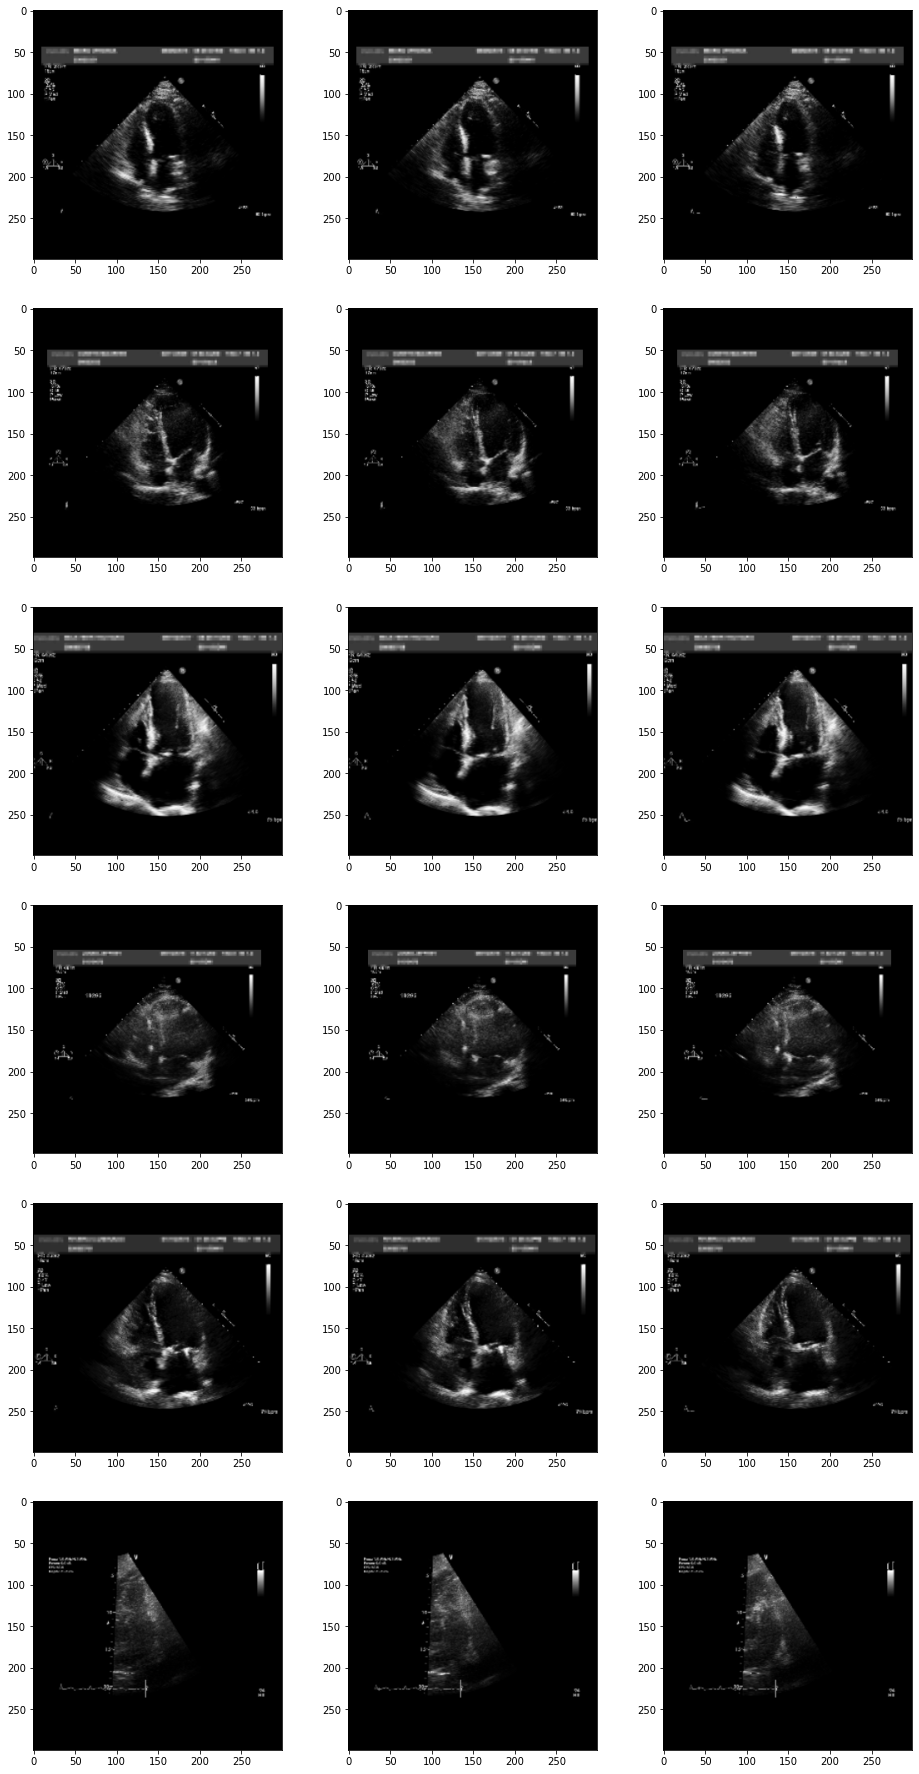

In [28]:
# Output batch is a list of dictionaries [INPUT, OUTPUT]:
image_batch = output[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)

# Show some images from the batch
#sample_idx = np.random.randint(batch_size, size=6)
sample_idx = np.arange(0, 6)
frame_idx = np.random.randint(n_frames, size=3)
fig, ax = plt.subplots(nrows=len(sample_idx), ncols=len(frame_idx), figsize = (16,32))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        ax[row, col].imshow(image, cmap = 'gray')